# Module 2: Time Series Analysis for H&H with Python

## Working with USGS daily discharge data (Mississippi River at St. Paul, MN) 🕒🌊

### Welcome!
In this module you’ll learn the time series skills you’ll use constantly in hydrology and hydraulics:
reading data, parsing dates, resampling, unit conversions, plotting hydrographs, and calculating common
summary statistics.

We’ll use a real dataset you can keep reusing: **USGS daily discharge (cfs)** for **USGS 05331000** (Mississippi River at St. Paul, Minnesota).

> **Note:** In this module we use **streamflow (discharge)** as our example time series. The same workflows apply to most water-resources time series you’ll work with, like **precipitation**, **snow water equivalent**, **water level/stage**, **groundwater levels**, **water temperature**, **turbidity**, and **water quality** measurements. Once you learn how to parse dates, clean data, resample, and visualize patterns, you can reuse these skills across datasets.


### What you’ll be able to do by the end
- Read a CSV time series and **parse datetime** correctly
- Set a datetime index and do **time-based slicing**
- Handle **missing values** and common data issues
- Convert units (cfs ↔ cms) and aggregate to different time steps (daily → monthly)
- Make the most common plots for time series:
  - hydrograph, monthly averages, rolling averages
  - flow duration curve
  - seasonal patterns (by month)
- Compute beginner-friendly time series stats (min/mean/max, percentiles, annual metrics)
- Use AI as a **pair programmer** (explain, write, debug, and improve your code)

### Using AI as your “pair programmer” for time series work

Good AI prompts for this module:
- “Explain what this code is doing line by line, and point out any assumptions.”
- “My CSV isn’t loading in Colab. Here’s the error. What does it mean and how do I fix the file path?”
- “Rewrite this plot to show monthly maximum instead of monthly mean.”
- “How would I adapt this workflow for precipitation time series instead of discharge?”


### Module structure
1. **Mental models** for time series
2. Load and clean USGS discharge data
3. Datetimes: parsing, time zones, indexing, slicing
4. Resampling and aggregation (daily → weekly/monthly)
5. Visualization patterns you’ll reuse in reports
6. Practical stats for H&H
7. Mini-project: a clean “hydrograph summary” workflow
8. Practice exercises (and a separate solutions notebook)

## Part 1: Mental models for time series 🧠

### A time series is just a table with a special column
In hydrology, almost everything is “value vs time”:
- rainfall hyetographs
- streamflow hydrographs
- stage records
- snow water equivalent (SWE)
- reservoir elevations

In Python, your job is to:
1. **Make sure time is truly a datetime type**
2. **Make time the index** (so slicing/resampling works cleanly)
3. Keep units and time step clear (daily vs hourly vs 15-min)

### A helpful rule
If your time column is still “object” or “string”, treat it as *not ready* for analysis.

## Part 2: Setup (run once) 🛠️

This module assumes you completed Module 1 and can run code cells in Colab.

We’ll use:
- `pandas` for data wrangling
- `matplotlib` for plotting
- `numpy` for numeric helpers

> If you ever see an import error, copy the error message and ask your AI assistant:
> “What do I need to install in Colab to fix this?”

In [30]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Optional: nicer display for wide tables
pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 120)

## Part 3: Load the USGS dataset 📥

In this Colab environment, your CSV is already available at:

`/mnt/data/Mississippi River at St. Paul, MN - USGS-05331000_Discharge_daily.csv`

We’ll:
- read the file
- inspect columns
- keep only what we need

## Getting the data into Colab (two options)

In real projects, your data might come from:
- a downloaded CSV (USGS, NOAA, local monitoring programs)
- a model output file
- a database or API

For this course, we’ll keep it simple and show **two beginner-friendly ways** to load a CSV into Colab:

1. **Upload a file from your computer**
2. **Read a file from your Google Drive**


In [31]:
# OPTION 1) Upload from your computer (recommended for first-time learners)
from google.colab import files

uploaded = files.upload()  # pick your CSV file
# After upload, we can grab the first uploaded filename:
uploaded_filename = next(iter(uploaded))
print("Uploaded file:", uploaded_filename)

# OPTION 2) Read from your Google Drive
# If you prefer Drive (or if the file is large), you can mount Drive and set a path.
# from google.colab import drive
# drive.mount('/content/drive')

# Example:
# drive_path = '/content/drive/MyDrive/path/to/your_file.csv'
# print("Drive path example:", drive_path)


Saving Mississippi River at St. Paul, MN - USGS-05331000_Discharge_daily.csv to Mississippi River at St. Paul, MN - USGS-05331000_Discharge_daily (2).csv
Uploaded file: Mississippi River at St. Paul, MN - USGS-05331000_Discharge_daily (2).csv


### Choose your input file path

- If you uploaded a file: use `uploaded_filename`
- If you mounted Google Drive: set `data_path = drive_path`

Tip: Keep your file names simple (avoid extra spaces) to reduce path mistakes.


In [32]:
# Pick ONE of the following:

# If you used files.upload()
data_path = uploaded_filename

# If you used Google Drive, uncomment and set your Drive path:
# data_path = '/content/drive/MyDrive/your_folder/your_file.csv'

print("Using data_path =", data_path)


Using data_path = Mississippi River at St. Paul, MN - USGS-05331000_Discharge_daily (2).csv


In [33]:
data_path = r"Mississippi River at St. Paul, MN - USGS-05331000_Discharge_daily (2).csv"
raw = pd.read_csv(data_path)

print("Rows, Columns:", raw.shape)
raw.head()

Rows, Columns: (9102, 12)


,x,y,statistic_id,parameter_code,qualifier,last_modified,time_series_id,monitoring_location_id,time,value,unit_of_measure,approval_status
0,-93.088111,44.944444,3,60,NaN,2025-03-11 07:56:58.928100+00:00,db30e0869a2a413e995cdc4a10d0fc5b,USGS-05331000,2024-12-01,4740,ft^3/s,Provisional
1,-93.088111,44.944444,3,60,NaN,2025-03-11 07:56:58.928100+00:00,db30e0869a2a413e995cdc4a10d0fc5b,USGS-05331000,2024-11-30,6810,ft^3/s,Provisional
2,-93.088111,44.944444,3,60,NaN,2025-03-11 07:56:58.928100+00:00,db30e0869a2a413e995cdc4a10d0fc5b,USGS-05331000,2024-11-29,9440,ft^3/s,Provisional
3,-93.088111,44.944444,3,60,NaN,2025-03-11 07:56:58.928100+00:00,db30e0869a2a413e995cdc4a10d0fc5b,USGS-05331000,2024-11-28,9800,ft^3/s,Provisional
4,-93.088111,44.944444,3,60,NaN,2025-03-11 07:56:58.928100+00:00,db30e0869a2a413e995cdc4a10d0fc5b,USGS-05331000,2024-11-27,10400,ft^3/s,Provisional


### Quick data audit
Before we do anything fancy, check:
- What columns exist?
- What type is the time column?
- Are there missing values?

In [34]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9102 entries, 0 to 9101
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   x                       9102 non-null   float64
 1   y                       9102 non-null   float64
 2   statistic_id            9102 non-null   int64  
 3   parameter_code          9102 non-null   int64  
 4   qualifier               2551 non-null   object 
 5   last_modified           9102 non-null   object 
 6   time_series_id          9102 non-null   object 
 7   monitoring_location_id  9102 non-null   object 
 8   time                    9102 non-null   object 
 9   value                   9102 non-null   int64  
 10  unit_of_measure         9102 non-null   object 
 11  approval_status         9102 non-null   object 
dtypes: float64(2), int64(3), object(7)
memory usage: 853.4+ KB


### Create a clean working table
We only need:
- `time` (date)
- `value` (discharge)
- optionally: `unit_of_measure`, `approval_status`

We’ll rename columns to something friendlier:
- `time` → `date`
- `value` → `Q_cfs`

In [35]:
df = raw.copy()

# Rename for clarity
df = df.rename(columns={"time": "date", "value": "Q_cfs"})

# Keep a tidy subset of columns (keep extras if you want)
keep_cols = ["date", "Q_cfs", "unit_of_measure", "approval_status", "last_modified"]
df = df[[c for c in keep_cols if c in df.columns]]

df.head()

,date,Q_cfs,unit_of_measure,approval_status,last_modified
0,2024-12-01,4740,ft^3/s,Provisional,2025-03-11 07:56:58.928100+00:00
1,2024-11-30,6810,ft^3/s,Provisional,2025-03-11 07:56:58.928100+00:00
2,2024-11-29,9440,ft^3/s,Provisional,2025-03-11 07:56:58.928100+00:00
3,2024-11-28,9800,ft^3/s,Provisional,2025-03-11 07:56:58.928100+00:00
4,2024-11-27,10400,ft^3/s,Provisional,2025-03-11 07:56:58.928100+00:00


## Part 4: Datetime parsing and indexing 🗓️

### Step 1: Convert the date column to datetime
`pd.to_datetime()` is the main tool.

Common issues you’ll see in real H&H datasets:
- mixed formats (`2024-01-05` vs `01/05/2024`)
- timestamps with time zones
- missing or invalid dates

We’ll convert, then verify the type.

In [36]:
df["date"] = pd.to_datetime(df["date"], errors="coerce")

print("date dtype:", df["date"].dtype)
print("Missing/invalid dates:", df["date"].isna().sum())
df.head()

date dtype: datetime64[ns]
Missing/invalid dates: 0


,date,Q_cfs,unit_of_measure,approval_status,last_modified
0,2024-12-01,4740,ft^3/s,Provisional,2025-03-11 07:56:58.928100+00:00
1,2024-11-30,6810,ft^3/s,Provisional,2025-03-11 07:56:58.928100+00:00
2,2024-11-29,9440,ft^3/s,Provisional,2025-03-11 07:56:58.928100+00:00
3,2024-11-28,9800,ft^3/s,Provisional,2025-03-11 07:56:58.928100+00:00
4,2024-11-27,10400,ft^3/s,Provisional,2025-03-11 07:56:58.928100+00:00


### Step 2: Sort and set the datetime index
This is where time series work becomes clean.

After setting the index:
- slicing by date becomes simple
- resampling works (daily → monthly)

In [37]:
df = df.sort_values("date").set_index("date")

df.index.name = "date"
df.head()

,Q_cfs,unit_of_measure,approval_status,last_modified
date,,,,
2000-01-01,6370,ft^3/s,Approved,2025-03-11 07:56:58.928100+00:00
2000-01-02,6410,ft^3/s,Approved,2025-03-11 07:56:58.928100+00:00
2000-01-03,6390,ft^3/s,Approved,2025-03-11 07:56:58.928100+00:00
2000-01-04,6280,ft^3/s,Approved,2025-03-11 07:56:58.928100+00:00
2000-01-05,6180,ft^3/s,Approved,2025-03-11 07:56:58.928100+00:00


### Step 3: Basic checks
- Is the index unique?
- Is the time step daily (mostly)?

In [38]:
print("Index unique?:", df.index.is_unique)
print("Date range:", df.index.min(), "to", df.index.max())

# Check typical spacing (in days)
deltas = df.index.to_series().diff().dropna()
print("Most common delta (days):")
print(deltas.dt.days.value_counts().head(5))

Index unique?: True
Date range: 2000-01-01 00:00:00 to 2024-12-01 00:00:00
Most common delta (days):
date
1    9101
Name: count, dtype: int64


### Handling missing values (and why it matters)
Missing discharge values happen due to:
- sensor downtime
- ice effects
- rating curve updates
- provisional gaps

You typically have 3 options:
1. **Leave as NaN** (often safest)
2. Fill by interpolation (careful for floods)
3. Fill with a constant or rolling statistic (rarely appropriate for streamflow)

We’ll just detect and keep NaNs for now.

In [39]:
print("Missing discharge values:", df["Q_cfs"].isna().sum())
df[df["Q_cfs"].isna()].head()

Missing discharge values: 0


,Q_cfs,unit_of_measure,approval_status,last_modified
date,,,,


## Part 5: Time-based slicing ⏱️

Once the index is datetime, you can select time windows easily.

Examples:
- a specific month: `"2025-05"`
- a date range: `"2025-03-01":"2025-06-01"`

In [40]:
# Example slices (adjust dates to match your dataset range)
example_month = df.loc[df.index.min().strftime("%Y-%m")]

example_range = df.loc[df.index.min(): df.index.min() + pd.Timedelta(days=30)]

print("Example month rows:", len(example_month))
print("Example 30-day range rows:", len(example_range))

example_range.head()

Example month rows: 31
Example 30-day range rows: 31


,Q_cfs,unit_of_measure,approval_status,last_modified
date,,,,
2000-01-01,6370,ft^3/s,Approved,2025-03-11 07:56:58.928100+00:00
2000-01-02,6410,ft^3/s,Approved,2025-03-11 07:56:58.928100+00:00
2000-01-03,6390,ft^3/s,Approved,2025-03-11 07:56:58.928100+00:00
2000-01-04,6280,ft^3/s,Approved,2025-03-11 07:56:58.928100+00:00
2000-01-05,6180,ft^3/s,Approved,2025-03-11 07:56:58.928100+00:00


## Part 6: Unit conversions (cfs ↔ cms) 📐

Hydrology work often mixes units. A clean habit:
- keep the original column
- create a new converted column with an explicit name

**1 cfs = 0.028316846592 m³/s**

In [41]:
CFS_TO_CMS = 0.028316846592

df["Q_cms"] = df["Q_cfs"] * CFS_TO_CMS
df[["Q_cfs", "Q_cms"]].head()

,Q_cfs,Q_cms
date,,
2000-01-01,6370,180.378313
2000-01-02,6410,181.510987
2000-01-03,6390,180.944650
2000-01-04,6280,177.829797
2000-01-05,6180,174.998112


## Part 7: The core plots for H&H time series 📊

We’ll build plots you’ll reuse in reports and quick checks:
1. Hydrograph (daily)
2. Rolling average (smooth trend)
3. Resampled hydrograph (monthly mean)
4. Seasonal pattern (by month)
5. Flow duration curve

### Plotting tip
Always label:
- y-axis units
- time period (in title)
- if you resampled, say so

### 7.1 Hydrograph (daily)
This is the first sanity-check plot for any streamflow dataset.

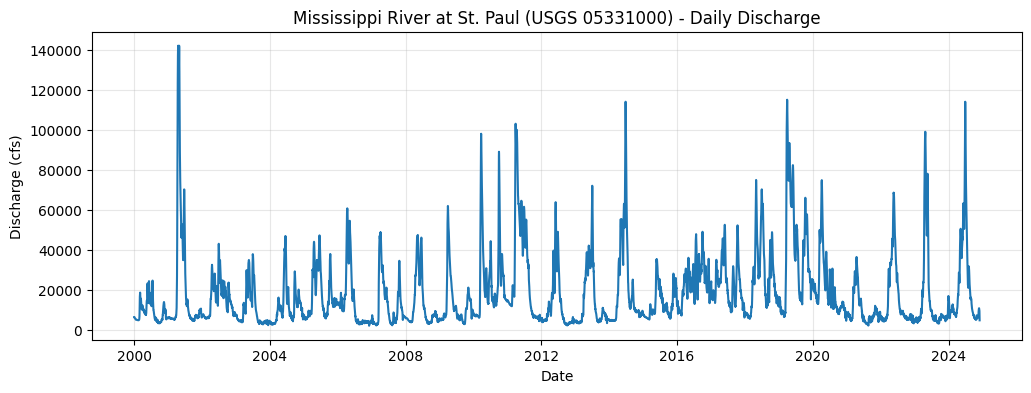

In [42]:
plt.figure(figsize=(12,4))
plt.plot(df.index, df["Q_cfs"])
plt.title("Mississippi River at St. Paul (USGS 05331000) - Daily Discharge")
plt.xlabel("Date")
plt.ylabel("Discharge (cfs)")
plt.grid(True, alpha=0.3)
plt.show()

## Raster hydrograph (year vs day-of-year)

A **raster hydrograph** is a compact way to visualize long daily time series:
- Each row is a year (or water year)
- Each column is day-of-year
- Color shows discharge magnitude

This helps you quickly see:
- wet vs dry years
- timing of spring snowmelt peaks
- multi-year shifts in seasonality


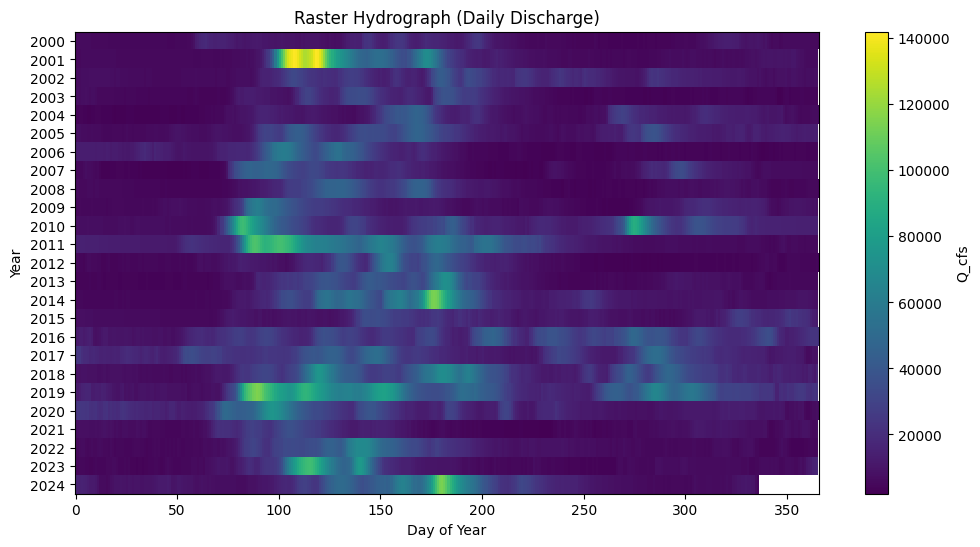

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assumes your cleaned dataframe is named df and has:
# - a datetime index
# - a discharge column in cfs named 'Q_cfs' (adjust if needed)

# Safety checks (beginner-friendly)
assert isinstance(df.index, pd.DatetimeIndex), "df must be indexed by datetime for this plot."
assert 'Q_cfs' in df.columns, "Expected a 'Q_cfs' column. Rename or adjust the code."

# Build a year x day-of-year matrix
tmp = df[['Q_cfs']].copy()
tmp['year'] = tmp.index.year
tmp['doy'] = tmp.index.dayofyear

# Pivot to make a matrix where rows=year, cols=day-of-year
mat = tmp.pivot_table(index='year', columns='doy', values='Q_cfs', aggfunc='mean')

# Plot
plt.figure(figsize=(12, 6))
plt.imshow(mat.values, aspect='auto', interpolation='nearest')
plt.colorbar(label='Q_cfs')
plt.yticks(ticks=np.arange(len(mat.index)), labels=mat.index.values)
plt.xlabel('Day of Year')
plt.ylabel('Year')
plt.title('Raster Hydrograph (Daily Discharge)')
plt.show()

# Optional: a water-year version (Oct-Sep) is often more meaningful in hydrology.
# Uncomment if you want water years:
# tmp['water_year'] = (tmp.index + pd.offsets.MonthBegin(3)).year  # shifts year boundary to Oct 1
# tmp['wy_doy'] = (tmp.index - pd.to_datetime(tmp['water_year'].astype(str) + '-10-01')).dt.days + 1
# mat_wy = tmp.pivot_table(index='water_year', columns='wy_doy', values='Q_cfs', aggfunc='mean')
# plt.figure(figsize=(12, 6))
# plt.imshow(mat_wy.values, aspect='auto', interpolation='nearest')
# plt.colorbar(label='Q_cfs')
# plt.yticks(ticks=np.arange(len(mat_wy.index)), labels=mat_wy.index.values)
# plt.xlabel('Day of Water Year (starting Oct 1)')
# plt.ylabel('Water Year')
# plt.title('Raster Hydrograph (Water Year)')
# plt.show()


### 7.2 Rolling average (smoothing)
Rolling windows help you see:
- seasonal trend
- whether a peak is a one-day spike vs a sustained event

We’ll add a 7-day and 30-day rolling mean.

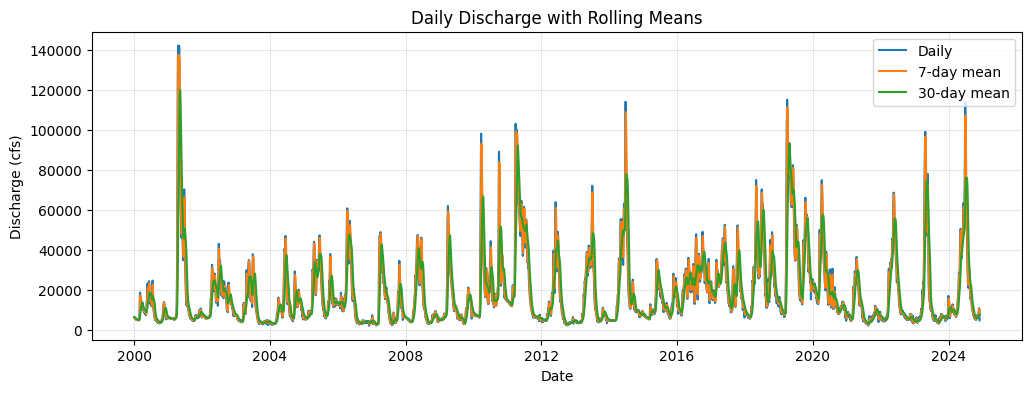

In [44]:
df["Q_cfs_roll7"] = df["Q_cfs"].rolling(window=7, min_periods=1).mean()
df["Q_cfs_roll30"] = df["Q_cfs"].rolling(window=30, min_periods=1).mean()

plt.figure(figsize=(12,4))
plt.plot(df.index, df["Q_cfs"], label="Daily")
plt.plot(df.index, df["Q_cfs_roll7"], label="7-day mean")
plt.plot(df.index, df["Q_cfs_roll30"], label="30-day mean")
plt.title("Daily Discharge with Rolling Means")
plt.xlabel("Date")
plt.ylabel("Discharge (cfs)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

### 7.3 Resampling (daily → monthly)
Resampling is how we change time steps.

Common hydrology examples:
- daily → monthly mean flow
- daily → annual max flow (for frequency analysis)
- hourly → daily totals (rainfall)

In pandas:
- `resample("M").mean()` gives monthly means (month-end labels)
- `resample("MS").mean()` gives monthly means (month-start labels)

We’ll compute both monthly mean and monthly max.

In [45]:
monthly_mean = df["Q_cfs"].resample("MS").mean()
monthly_max  = df["Q_cfs"].resample("MS").max()

monthly = pd.DataFrame({"Q_cfs_mean_month": monthly_mean, "Q_cfs_max_month": monthly_max})
monthly.head()

,Q_cfs_mean_month,Q_cfs_max_month
date,,
2000-01-01,5476.451613,6410
2000-02-01,5365.517241,12600
2000-03-01,13654.838710,18600
2000-04-01,9654.000000,11500
2000-05-01,13452.258065,23200


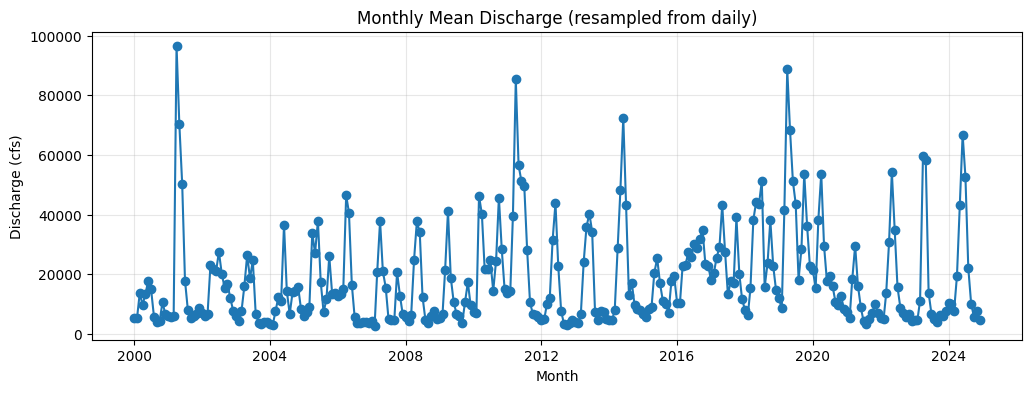

In [46]:
plt.figure(figsize=(12,4))
plt.plot(monthly.index, monthly["Q_cfs_mean_month"], marker="o")
plt.title("Monthly Mean Discharge (resampled from daily)")
plt.xlabel("Month")
plt.ylabel("Discharge (cfs)")
plt.grid(True, alpha=0.3)
plt.show()

### 7.4 Seasonal pattern by month
A simple seasonal view is: average discharge for each calendar month.

We’ll:
- create a `month` column
- compute mean and percentile bands by month

In [47]:
df_season = df.copy()
df_season["month"] = df_season.index.month

month_stats = df_season.groupby("month")["Q_cfs"].agg(
    mean="mean",
    p10=lambda x: np.nanpercentile(x, 10),
    p50=lambda x: np.nanpercentile(x, 50),
    p90=lambda x: np.nanpercentile(x, 90),
)

month_stats

,mean,p10,p50,p90
month,,,,
1,8007.651613,4004.0,6350.0,14660.0
2,7387.057992,3616.0,5660.0,13940.0
3,17087.058065,4962.0,10100.0,33800.0
4,36526.600000,9958.0,29050.0,80610.0
5,35469.690323,14500.0,33400.0,61660.0
6,32124.786667,11980.0,27950.0,58900.0
7,22988.735484,5420.0,16500.0,49120.0
8,11612.709677,3900.0,8920.0,23400.0
9,11060.106667,3350.0,7395.0,25010.0


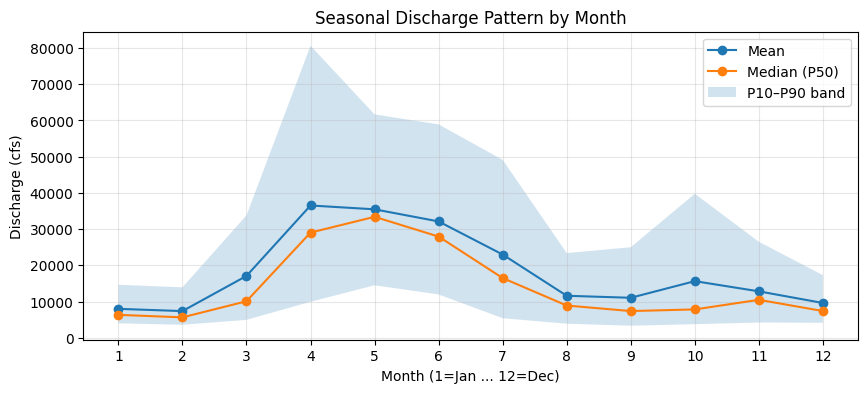

In [48]:
plt.figure(figsize=(10,4))
plt.plot(month_stats.index, month_stats["mean"], marker="o", label="Mean")
plt.plot(month_stats.index, month_stats["p50"], marker="o", label="Median (P50)")
plt.fill_between(month_stats.index, month_stats["p10"], month_stats["p90"], alpha=0.2, label="P10–P90 band")
plt.title("Seasonal Discharge Pattern by Month")
plt.xlabel("Month (1=Jan ... 12=Dec)")
plt.ylabel("Discharge (cfs)")
plt.xticks(range(1,13))
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

### 7.5 Flow Duration Curve (FDC)
An FDC answers:
> “What flow is exceeded X% of the time?”

This plot is common in:
- water supply and reliability studies
- ecological flow analysis
- quick comparison across basins

Steps:
1. Sort flows from high to low
2. Compute exceedance probability

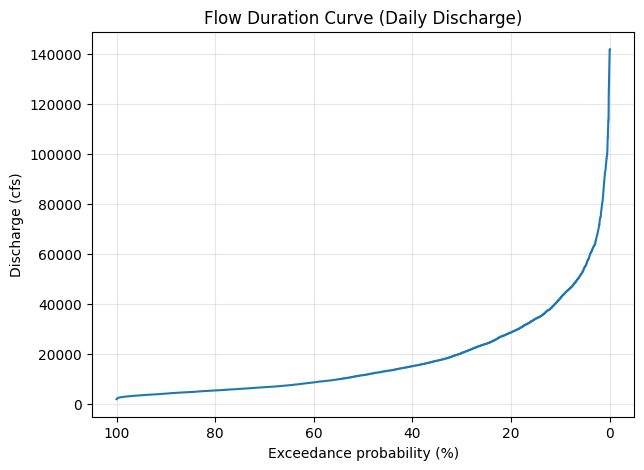

In [49]:
q = df["Q_cfs"].dropna().to_numpy()
q_sorted = np.sort(q)[::-1]  # descending
n = len(q_sorted)

exceedance = np.arange(1, n+1) / (n+1) * 100  # percent

plt.figure(figsize=(7,5))
plt.plot(exceedance, q_sorted)
plt.title("Flow Duration Curve (Daily Discharge)")
plt.xlabel("Exceedance probability (%)")
plt.ylabel("Discharge (cfs)")
plt.grid(True, alpha=0.3)
plt.gca().invert_xaxis()  # common convention: high flows on the left
plt.show()

## Part 8: Practical time series statistics for H&H 📈

### 8.1 Basic summary stats
These help with quick QA/QC and reporting.

In [50]:
summary = df["Q_cfs"].describe(percentiles=[0.05, 0.1, 0.5, 0.9, 0.95]).to_frame(name="Q_cfs")
summary

,Q_cfs
count,9102.000000
mean,18422.375302
std,18289.466929
min,2040.000000
5%,3620.000000
10%,4290.000000
50%,11700.000000
90%,42500.000000
95%,55100.000000
max,142000.000000


### 8.2 Peak flow and date
Engineers often need: “What was the peak discharge and when did it occur?”

In [51]:
peak_q = df["Q_cfs"].max()
peak_date = df["Q_cfs"].idxmax()

print("Peak discharge (cfs):", peak_q)
print("Peak date:", peak_date.date())

Peak discharge (cfs): 142000
Peak date: 2001-04-18


### 8.3 Water year (common in USGS-style analyses)
In the U.S., a common convention is the **water year**:
- Water Year 2025 runs from **Oct 1, 2024 → Sep 30, 2025**

We’ll compute:
- water year label
- annual (water year) max discharge

In [52]:
def water_year(dti):
    # dti: pandas DatetimeIndex or Series of timestamps
    # Water year increments on Oct 1
    return np.where(dti.month >= 10, dti.year + 1, dti.year)

df_wy = df.copy()
df_wy["water_year"] = water_year(df_wy.index)

annual_wy_max = df_wy.groupby("water_year")["Q_cfs"].max().sort_index()
annual_wy_mean = df_wy.groupby("water_year")["Q_cfs"].mean().sort_index()

pd.DataFrame({"WY_max_cfs": annual_wy_max, "WY_mean_cfs": annual_wy_mean})

,WY_max_cfs,WY_mean_cfs
water_year,,
2000,24600,10017.664234
2001,142000,23896.465753
2002,43000,14168.958904
2003,37800,12603.123288
2004,46900,9989.781421
2005,47200,16273.068493
2006,60700,17566.684932
2007,48700,10646.684932
2008,47400,14468.633880


## Part 9: Using AI as your pair programmer 🤖

You’re not expected to memorize time series code. Instead, get good at *asking for help the right way*.

### 3 prompts you can reuse immediately
1. **Explain**
   - “Explain what this code is doing line by line, in simple terms.”
2. **Write**
   - “Write Python code (pandas) to resample daily discharge to monthly mean and monthly max, and plot both.”
3. **Debug**
   - “Here is my error message and my code. What is wrong, and how do I fix it?”

### A mini-workflow prompt (copy/paste)
> I have a CSV with columns `date` and `Q_cfs`.  
> Please write clean, beginner-friendly pandas code that:
> 1) parses `date` as datetime  
> 2) sets it as index and sorts  
> 3) checks for missing values  
> 4) creates a `Q_cms` column  
> 5) makes a hydrograph plot and a flow duration curve  
> Add short comments to explain each step.

## Part 10: Mini-project: a reusable “hydrograph summary” workflow ✅

Goal: produce a small table and two plots that you can reuse for any station.

Outputs:
- Summary table: date range, n days, min/mean/max, peak date
- Plot 1: hydrograph with 7-day rolling mean
- Plot 2: flow duration curve

This is the kind of workflow you can turn into a function later.

In [53]:
# --- Summary table ---
q_series = df["Q_cfs"].dropna()

summary_table = pd.DataFrame({
    "Metric": ["Start date", "End date", "Number of days", "Min (cfs)", "Mean (cfs)", "Max (cfs)", "Peak date"],
    "Value": [
        df.index.min().date(),
        df.index.max().date(),
        int(q_series.shape[0]),
        float(q_series.min()),
        float(q_series.mean()),
        float(q_series.max()),
        q_series.idxmax().date(),
    ]
})

summary_table

,Metric,Value
0,Start date,2000-01-01
1,End date,2024-12-01
2,Number of days,9102
3,Min (cfs),2040.0
4,Mean (cfs),18422.375302
5,Max (cfs),142000.0
6,Peak date,2001-04-18


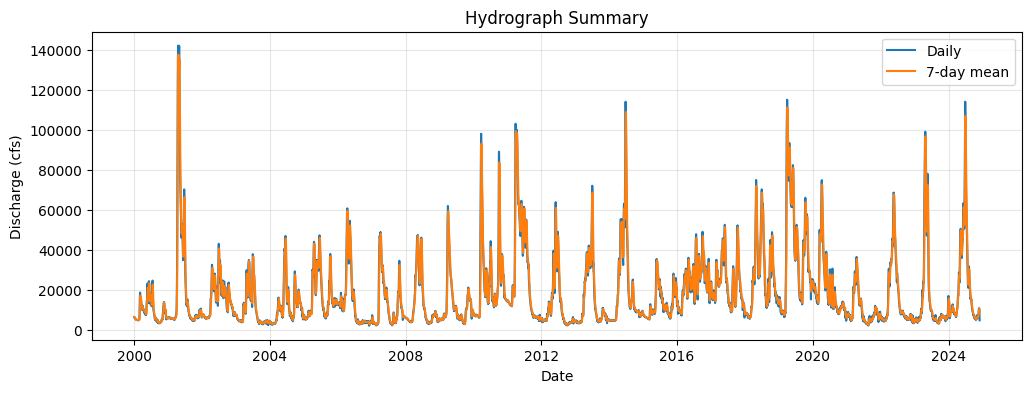

In [54]:
# --- Plot 1: hydrograph + 7-day rolling mean ---
plt.figure(figsize=(12,4))
plt.plot(df.index, df["Q_cfs"], label="Daily")
plt.plot(df.index, df["Q_cfs_roll7"], label="7-day mean")
plt.title("Hydrograph Summary")
plt.xlabel("Date")
plt.ylabel("Discharge (cfs)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

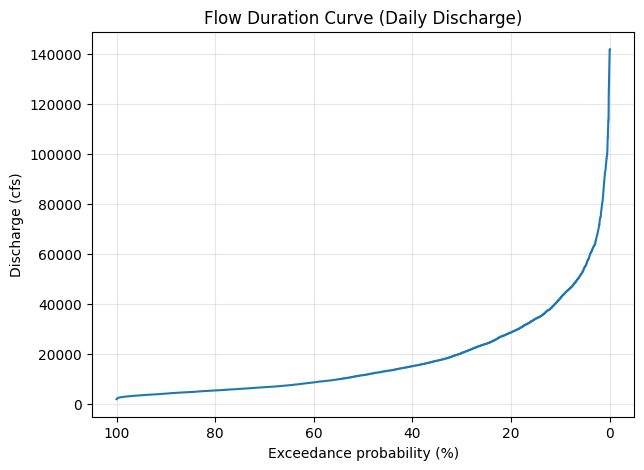

In [55]:
# --- Plot 2: Flow Duration Curve ---
q = q_series.to_numpy()
q_sorted = np.sort(q)[::-1]
n = len(q_sorted)
exceedance = np.arange(1, n+1) / (n+1) * 100

plt.figure(figsize=(7,5))
plt.plot(exceedance, q_sorted)
plt.title("Flow Duration Curve (Daily Discharge)")
plt.xlabel("Exceedance probability (%)")
plt.ylabel("Discharge (cfs)")
plt.grid(True, alpha=0.3)
plt.gca().invert_xaxis()
plt.show()

## Practice Exercises 🎯

Try these without looking anything up first. Then use your AI assistant if you get stuck.

### Exercise 1: Parse and index
1. Load the CSV again into a new DataFrame called `df2`
2. Rename `time` → `date`, `value` → `Q_cfs`
3. Convert `date` to datetime and set it as the index
4. Print the date range and number of rows

*(Write your code in the cell below.)*

In [ ]:
# EXERCISE 1 - YOUR CODE HERE

### Exercise 2: Monthly plot (mean and max)
1. From `df2`, compute monthly mean and monthly max discharge
2. Plot both on the same figure with a legend

Tip: use `resample("MS")`.

In [ ]:
# EXERCISE 2 - YOUR CODE HERE

### Exercise 3: Convert to cms and report a percentile
1. Create a `Q_cms` column in `df2`
2. Compute the 90th percentile (P90) of `Q_cms`
3. Print it with a clear label

In [ ]:
# EXERCISE 3 - YOUR CODE HERE

### Exercise 4: 14-day rolling statistics
1. Create a 14-day rolling mean series from `Q_cfs`
2. Find the date where the rolling mean is maximum
3. Make a plot showing daily flow and the 14-day rolling mean

In [ ]:
# EXERCISE 4 - YOUR CODE HERE

### Exercise 5: Flow duration curve function (optional stretch)
Write a function `flow_duration_curve(series)` that:
- takes a pandas Series of flows
- returns a DataFrame with columns `exceedance_pct` and `flow`
- and makes an FDC plot

Use your AI assistant to help, but make sure you understand the final code.

In [ ]:
# EXERCISE 5 - YOUR CODE HERE

## 🎉 What you can now do
You now have the core building blocks for time series analysis in H&H:
- clean datetime parsing and indexing
- resampling to different time steps
- common plots (hydrograph, rolling mean, seasonal patterns, FDC)
- simple stats for reporting and QA/QC

Next modules can build on this by adding:
- frequency analysis (annual maxima, fitting distributions)
- event detection (peaks and hydrograph separation)
- rainfall-runoff comparisons and lag analysis